# Imports

In [3]:
import os
os.chdir("/Users/evanrootness/DS_Projects/EtsyDSProject")
pwd = os.getcwd()
print(pwd)

/Users/evanrootness/DS_Projects/EtsyDSProject


In [463]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.optimize as opt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import re

In [658]:
import_data = pd.read_csv(pwd + '/data/ArtAllPages.csv')
# import_data = pd.read_csv(pwd + '/data/art_map.csv')
raw_data = import_data.copy()

# Data Cleaning

In [659]:
data = raw_data.drop(['web-scraper-order', 'web-scraper-start-url', 'product_link-href', 'Pagination', 'product_link'], axis = 1)

In [660]:
print(data.shape)
data

(1111, 3)


,name,min_price,size_options
0,"Pastel Art, Mint Green Wall Art, Mint Green Ar...",Price:\n $6.00,[]
1,"San Francisco Print, Golden Gate Bridge Wall A...",Price:\n $18.00+,"[{""size_options"":""Select an option\n ..."
2,"Set 4 Coral Prints Mist Blue/Green, Nautical p...",Price:\n $82.00+,"[{""size_options"":""Select a size\n ..."
3,Whale nursery art. Whale Rider print,Price:\n $20.00+,"[{""size_options"":""Select a size\n ..."
4,Valentine's Day Copper Rose / Seventh Annivers...,Price:\n $160.00+,"[{""size_options"":""Select an option\n ..."
...,...,...,...
1106,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",Price:\n $4.80,[]
1107,"Tropical Little Thing Mini Crab, Driftwood Wal...",Price:\n $150.00,[]
1108,"Fall Pumpkin Mug Sublimation, Watercolor Flora...",Price:\n $2.00,[]
1109,Pheasant Art Print Giclee Limited Edition,Price:\n $39.89,[]


In [661]:
data.describe()

,name,min_price,size_options
count,1111,1111,1111
unique,1041,508,412
top,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",Price:\n $18.00+,[]
freq,5,32,547


In [662]:
data = data.astype(dtype='string')
data.dtypes

name            string[python]
min_price       string[python]
size_options    string[python]
dtype: object

In [663]:
price = []

for i in range(len(data['min_price'])):
    price.append(re.search('[^+]*', data['min_price'][i]).group(0))
    price[i] = re.search('[^\$]*$', price[i]).group(0).replace(',', '')

data['min_price'] = price
data['min_price'] = data['min_price'].astype(float)

## Convert Names to Categorical Data

In [664]:
sys.path.insert(1, '/Users/evanrootness/DS_Projects/EtsyDSProject/py_scripts/')
import scripts_explore

In [665]:
# one-hot encode categorical data from listing names (encode most popular keywords)
data = scripts_explore.addCategoricalLists(data, ['Watercolor', 'Portrait', 'Pet', 'Print', 'Family', 'Paint', 'Painting', 'Nature', 'Custom', 'Abstract', 'House', 'Map'])

In [666]:
# I don't want to include maps in my analysis so get rid of them
data = data.query('Map != 1')
data = data.drop(columns='Map')
data = data.reset_index(drop=True)

In [667]:
data

,name,min_price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom,Abstract,House
0,"Pastel Art, Mint Green Wall Art, Mint Green Ar...",6.00,[],1,0,0,1,0,0,0,0,0,1,0
1,"San Francisco Print, Golden Gate Bridge Wall A...",18.00,"[{""size_options"":""Select an option\n ...",0,0,0,1,0,0,0,0,0,0,0
2,"Set 4 Coral Prints Mist Blue/Green, Nautical p...",82.00,"[{""size_options"":""Select a size\n ...",0,0,0,1,0,0,0,0,0,0,0
3,Whale nursery art. Whale Rider print,20.00,"[{""size_options"":""Select a size\n ...",0,0,0,0,0,0,0,0,0,0,0
4,Valentine's Day Copper Rose / Seventh Annivers...,160.00,"[{""size_options"":""Select an option\n ...",0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",4.80,[],0,0,0,0,0,0,0,0,0,0,0
1049,"Tropical Little Thing Mini Crab, Driftwood Wal...",150.00,[],0,0,0,0,0,0,0,0,0,0,1
1050,"Fall Pumpkin Mug Sublimation, Watercolor Flora...",2.00,[],1,0,0,0,0,0,0,0,0,0,0
1051,Pheasant Art Print Giclee Limited Edition,39.89,[],0,0,0,1,0,0,0,0,0,0,0


## Convert "size options" to price and size lists

In [670]:
# example of string that needs to be parsed into sizes and prices
data['size_options'][27]

'[]'

Types of patterns we need to match for sizes:
- "#x#" (inches assumed, but no units)
- "#x# inches"
- "# x # inches"
- "#x#in"
- "#x#cm"
- "#x# cm"
- '#\\" x #\\" inches'

In [669]:
pattern = r'(\d+)\\" x (\d+)\\"'
string = data['size_options'][27]
matches = re.findall(pattern, string)
# floats_only = [(float(match[0]), float(match[2])) for match in matches]
# floats_only
matches

[]

In [671]:
data

,name,min_price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom,Abstract,House
0,"Pastel Art, Mint Green Wall Art, Mint Green Ar...",6.00,[],1,0,0,1,0,0,0,0,0,1,0
1,"San Francisco Print, Golden Gate Bridge Wall A...",18.00,"[{""size_options"":""Select an option\n ...",0,0,0,1,0,0,0,0,0,0,0
2,"Set 4 Coral Prints Mist Blue/Green, Nautical p...",82.00,"[{""size_options"":""Select a size\n ...",0,0,0,1,0,0,0,0,0,0,0
3,Whale nursery art. Whale Rider print,20.00,"[{""size_options"":""Select a size\n ...",0,0,0,0,0,0,0,0,0,0,0
4,Valentine's Day Copper Rose / Seventh Annivers...,160.00,"[{""size_options"":""Select an option\n ...",0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",4.80,[],0,0,0,0,0,0,0,0,0,0,0
1049,"Tropical Little Thing Mini Crab, Driftwood Wal...",150.00,[],0,0,0,0,0,0,0,0,0,0,1
1050,"Fall Pumpkin Mug Sublimation, Watercolor Flora...",2.00,[],1,0,0,0,0,0,0,0,0,0,0
1051,Pheasant Art Print Giclee Limited Edition,39.89,[],0,0,0,1,0,0,0,0,0,0,0


In [672]:
# the regex patterns to match
prices_pattern = re.compile('\$(.+?)\)')

pattern_nothing = r'(\d+)x(\d+)'
pattern_nothing_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?)'
pattern_space_nothing = r'(\d+) x (\d+)'

pattern_space_space_inches = r'(\d+) x (\d+)(?= in)'
pattern_space_inches = r'(\d+)?x(\d+)(?= in)'
pattern_inches = r'(\d+)x(\d+)(?=in)'
pattern_space_space_inches_dec = r'(\d+(\.\d+)?) x (\d+(\.\d+)?(?= in))'
pattern_space_inches_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?= in))'
pattern_inches_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?=in))'

pattern_space_space_cm = r'(\d+) x (\d+)(?= cm)'
pattern_space_cm = r'(\d+)?x(\d+)(?= cm)'
pattern_cm = r'(\d+)x(\d+)(?=cm)'
pattern_space_space_cm_dec = r'(\d+(\.\d+)?) x (\d+(\.\d+)?(?= cm))'
pattern_space_cm_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?= cm))'
pattern_cm_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?=cm))'

weird_pattern = r'(\d+)\\" x (\d+)\\"'

# initialize empty lists
prices = []
sizes = []
inches = []

In [673]:
#iterate through each listing to get a list of the size/price options
for text in data['size_options']:
    
    # find all possible matches in the input string
    nothing_matches = re.findall(pattern_nothing, text)
    nothing_matches_dec = re.findall(pattern_nothing_dec, text)
    sp_nothing_matches = re.findall(pattern_space_nothing, text)
    
    spsp_inches_matches = re.findall(pattern_space_space_inches, text)
    sp_inches_matches = re.findall(pattern_space_inches, text)
    inches_matches = re.findall(pattern_inches, text)
    spsp_inches_matches_dec = re.findall(pattern_space_space_inches_dec, text)
    sp_inches_matches_dec = re.findall(pattern_space_inches_dec, text)
    inches_matches_dec = re.findall(pattern_inches_dec, text)
    
    spsp_cm_matches = re.findall(pattern_space_space_cm, text)
    sp_cm_matches = re.findall(pattern_space_cm, text)
    cm_matches = re.findall(pattern_cm, text)
    spsp_cm_matches_dec = re.findall(pattern_space_space_cm_dec, text)
    sp_cm_matches_dec = re.findall(pattern_space_cm_dec, text)
    cm_matches_dec = re.findall(pattern_cm_dec, text)
    
    weird_matches = re.findall(weird_pattern, text)
    
    price_matches = re.findall(prices_pattern, text)
    
    # append current listing's list to temporary list    
    if (not not spsp_inches_matches):
        sizes.append(spsp_inches_matches)
        inches.append(1)
    elif (not not sp_inches_matches):
        sizes.append(sp_inches_matches)
        inches.append(1)
    elif (not not inches_matches):
        sizes.append(inches_matches)
        inches.append(1)
        
    elif (not not spsp_inches_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in spsp_inches_matches_dec])
        inches.append(1)
    elif (not not sp_inches_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in sp_inches_matches_dec])
        inches.append(1)
    elif (not not inches_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in inches_matches_dec])
        inches.append(1)
        
        
    elif (not not weird_matches):
        sizes.append(weird_matches)
        inches.append(1)
       
        
    elif (not not spsp_cm_matches):
        sizes.append(spsp_cm_matches) 
        inches.append(0)
    elif (not not sp_cm_matches):
        sizes.append(sp_cm_matches)
        inches.append(0)
    elif (not not cm_matches):
        sizes.append(cm_matches)
        inches.append(0)
        
    elif (not not spsp_cm_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in spsp_cm_matches_dec])
        inches.append(0)
    elif (not not sp_cm_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in sp_cm_matches_dec])
        inches.append(0)
    elif (not not cm_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in cm_matches_dec])
        inches.append(0)
    
    
    elif (not not nothing_matches):
        sizes.append(nothing_matches)
        inches.append(1)
    elif (not not nothing_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in nothing_matches_dec])
        inches.append(1)
    elif (not not sp_nothing_matches):
        sizes.append(sp_nothing_matches)
        inches.append(1)
        
    else:
        sizes.append(np.nan)
        inches.append(np.nan)
    
    if (not not price_matches):
        prices.append(price_matches)
    else:
        prices.append(np.nan)
    
# add new column on data with list of prices
data['prices'] = prices
data['sizes'] = sizes
data['inches'] = inches

# drop old column
# data.drop(data['size_options'])

In [674]:
print(data['sizes'].dropna().count())

342


In [684]:
data_sizes = data.dropna(subset=['sizes', 'prices'])
data_sizes = data_sizes.reset_index(drop=False)
# data_sizes

## Clean prices

In [686]:
data_sizes.loc[data_sizes['index'] == 1042]

,index,name,min_price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom,Abstract,House,prices,sizes,inches
336,1042,Kangaroo Art Print - Rustic Australian Interio...,19.0,"[{""size_options"":""Select a size\n ...",0,0,0,1,0,0,0,0,0,0,0,"[19.00 - $22.00, 29.00 - $32.00, 39.00 - $42.0...","[(8, 10), (12, 16), (16, 20), (18, 24), (24, 3...",1.0


In [692]:
data_sizes.iloc[237]['size_options']

'[{"size_options":"Select a size\\n                \\n                \\n                        5x7\\" ($12.13)\\n                \\n                \\n                        A5 ($12.13)\\n                \\n                \\n                        8x10\\" ($24.25)\\n                \\n                \\n                        A4 ($24.25)\\n                \\n                \\n                        11x14\\" ($48.50)\\n                \\n                \\n                        A3 ($48.50)"}]'

In [694]:
data_sizes['prices'].iloc[0]

['18.00',
 '36.00',
 '56.00',
 '71.00',
 '102.00',
 '128.00',
 '138.00',
 '153.00',
 '163.00']

In [723]:
# get rid of commas and ranges in prices, and convert to floats
price_list = []
for i in range(len(data_sizes)):
    # get rid of ranged prices
    temp_prices = []
    for j in range(len(data_sizes['prices'].iloc[i])):
        if ('-' in data_sizes['prices'].iloc[i][j]):
            temp_prices.append(data_sizes['prices'].iloc[i][j].split()[0])
        else:
            temp_prices.append(data_sizes['prices'].iloc[i][j])
    price_list.append(temp_prices)
        
    # get rid of commas in prices
    for j in range(len(price_list[i])):
        if (',' in price_list[i][j]):
            price_list[i][j] = price_list[i][j].replace(',', '')
        
# convert to floats
price_list_float = []

for ilist in price_list:
    temp_list = []
    if type(ilist) is list:
        for string in ilist:
            temp_list.append(float(string))
    else:
        temp_list.append(float(ilist))
    price_list_float.append(temp_list)
    
# print(price_list_float)
data_sizes['prices'] = price_list_float

## Create new features

In [725]:
# convert cm to inches
cm_to_inch_conv = 2.54
sizes_list = []
for i in range(len(data_sizes)):
    # if the size is currently in cm
    if (data_sizes['inches'].iloc[i] == 0):
        temp_sizes = []
        for j in range(len(data_sizes['sizes'].iloc[i])):
            width_in = float(data_sizes['sizes'].iloc[i][j][0]) / cm_to_inch_conv
            height_in = float(data_sizes['sizes'].iloc[i][j][1]) / cm_to_inch_conv
            temp_sizes.append((width_in, height_in))
        sizes_list.append(temp_sizes)
            
    else:
        sizes_list.append(data_sizes['sizes'].iloc[i])
# sizes_list
data_sizes['sizes_in'] = sizes_list

In [726]:
data_sizes['prices']

0      [18.0, 36.0, 56.0, 71.0, 102.0, 128.0, 138.0, ...
1      [82.0, 128.0, 178.0, 336.0, 448.0, 564.0, 628....
2                                     [40.0, 30.0, 20.0]
3                          [33.23, 44.68, 91.66, 126.03]
4      [38.25, 52.7, 52.7, 57.8, 57.8, 68.85, 68.85, ...
                             ...                        
335       [13.6, 25.5, 42.5, 51.0, 76.5, 114.75, 148.75]
336           [19.0, 29.0, 39.0, 49.0, 59.0, 59.0, 69.0]
337           [49.5, 64.8, 79.2, 81.0, 49.5, 64.8, 81.0]
338                                  [48.0, 125.0, 22.0]
339                                   [14.0, 19.0, 24.0]
Name: prices, Length: 340, dtype: object

In [727]:
# create area lists
areas_list = []
for i in range(len(data_sizes)):
    
    temp_areas = []
    for j in range(len(data_sizes['sizes_in'].iloc[i])):
        width_in = float(data_sizes['sizes_in'].iloc[i][j][0])
        height_in = float(data_sizes['sizes_in'].iloc[i][j][1])
        temp_areas.append(width_in * height_in)
    areas_list.append(temp_areas)
    
data_sizes['areas'] = areas_list
    

In [728]:
data_sizes['areas']

0      [35.0, 80.0, 154.0, 192.0, 320.0, 480.0, 600.0...
1      [35.0, 80.0, 154.0, 320.0, 432.0, 864.0, 320.0...
2                                    [154.0, 80.0, 35.0]
3      [223.2004464008928, 542.50108500217, 1085.0021...
4      [35.0, 80.0, 88.0, 154.0, 176.0, 192.0, 216.0,...
                             ...                        
335      [35.0, 80.0, 154.0, 192.0, 320.0, 480.0, 720.0]
336    [80.0, 192.0, 320.0, 432.0, 768.0, 864.0, 1200.0]
337                           [35.0, 80.0, 154.0, 192.0]
338                                       [216.0, 600.0]
339                                  [35.0, 80.0, 154.0]
Name: areas, Length: 340, dtype: object

In [751]:
data_sizes['size_options'][3]

'[{"size_options":"Select an option\\n                \\n                \\n                        Size 21x29.7cm ($33.23)\\n                \\n                \\n                        Size 32x45cm ($44.68)\\n                \\n                \\n                        Size 50x70cm ($91.66)\\n                \\n                \\n                        Size 70x100cm ($126.03)"}]'

In [752]:
data_sizes['areas'][3]

[223.2004464008928, 542.50108500217, 1085.00217000434]

In [753]:
# calculate price per square inch (ppsi)
ppsi_list = []
for i in range(len(data_sizes)):
    
    temp_ppsis = []
    
    if (len(data_sizes['prices'][i]) == len(data_sizes['areas'][i])):
        
        for j in range(len(data_sizes['prices'].iloc[i])):
            temp_ppsis.append(data_sizes['prices'].iloc[i][j] / data_sizes['areas'].iloc[i][j])
            
        ppsi_list.append(temp_ppsis)
        
    else:
        ppsi_list.append(np.nan)
    
data_sizes['ppsi'] = ppsi_list

In [761]:
data_sizes['ppsi'][1]

[2.342857142857143,
 1.6,
 1.155844155844156,
 1.05,
 1.037037037037037,
 0.6527777777777778,
 1.9625,
 1.9625,
 3.038961038961039,
 1.4537037037037037,
 0.9321428571428572]

In [763]:
data_sizes['sizes'].iloc[1]

[('5', '7'),
 ('8', '10'),
 ('14', '11'),
 ('16', '20'),
 ('18', '24'),
 ('24', '36'),
 ('16', '20'),
 ('16', '20'),
 ('11', '14'),
 ('18', '24'),
 ('28', '40')]

# Data Exploration

In [ ]:
# sns.heatmap(data_num_int.corr())

(array([1.037e+03, 2.300e+01, 1.100e+01, 1.100e+01, 5.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+01]),
 array([1.800000e-01, 1.801620e+02, 3.601440e+02, 5.401260e+02,
        7.201080e+02, 9.000900e+02, 1.080072e+03, 1.260054e+03,
        1.440036e+03, 1.620018e+03, 1.800000e+03]),
 <BarContainer object of 10 artists>)

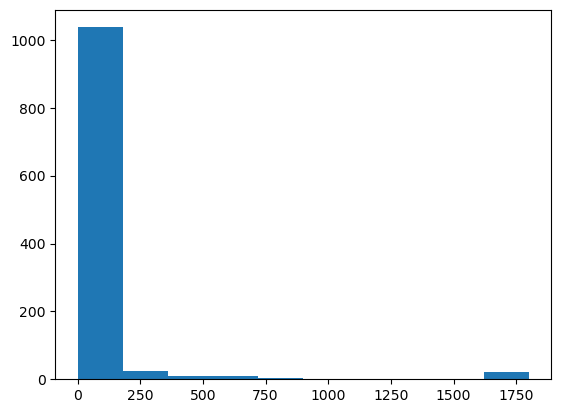

In [ ]:
plt.hist(data['price'])

In [ ]:
data_cheap = data.where(data['price'] < 200).dropna()
data_expensive = data.where(data['price'] > 200).dropna()

(array([526., 309.,  99.,  36.,  24.,  18.,   7.,  11.,   4.,   7.]),
 array([1.80000e-01, 2.01170e+01, 4.00540e+01, 5.99910e+01, 7.99280e+01,
        9.98650e+01, 1.19802e+02, 1.39739e+02, 1.59676e+02, 1.79613e+02,
        1.99550e+02]),
 <BarContainer object of 10 artists>)

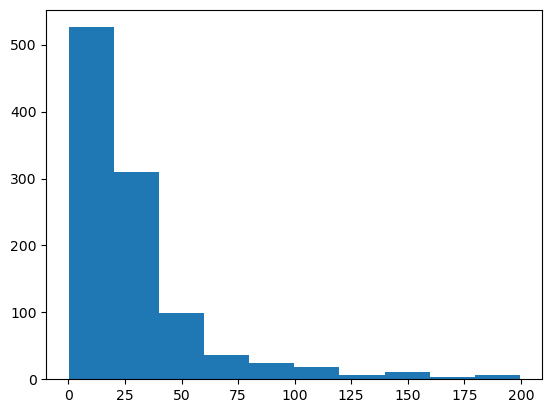

In [ ]:
plt.hist(data_cheap['price'])

(array([18., 11.,  8.,  8.,  1.,  0.,  1.,  0.,  2., 20.]),
 array([ 210.,  369.,  528.,  687.,  846., 1005., 1164., 1323., 1482.,
        1641., 1800.]),
 <BarContainer object of 10 artists>)

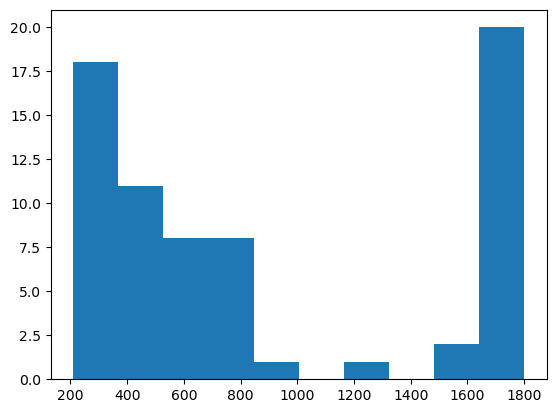

In [ ]:
plt.hist(data_expensive['price'])

## Histograms of individual categories

(array([2., 0., 0., 1., 2., 1., 1., 1., 1., 1.]),
 array([ 6.75 , 11.575, 16.4  , 21.225, 26.05 , 30.875, 35.7  , 40.525,
        45.35 , 50.175, 55.   ]),
 <BarContainer object of 10 artists>)

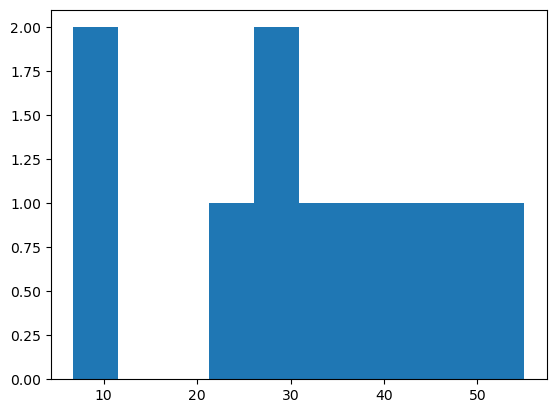

In [ ]:
plt.hist(data.where(data['Pet'] == 1).dropna()['price'].astype(float))

(array([44., 30.,  5.,  2.,  1.,  0.,  3.,  2.,  0.,  2.]),
 array([  2. ,  17.1,  32.2,  47.3,  62.4,  77.5,  92.6, 107.7, 122.8,
        137.9, 153. ]),
 <BarContainer object of 10 artists>)

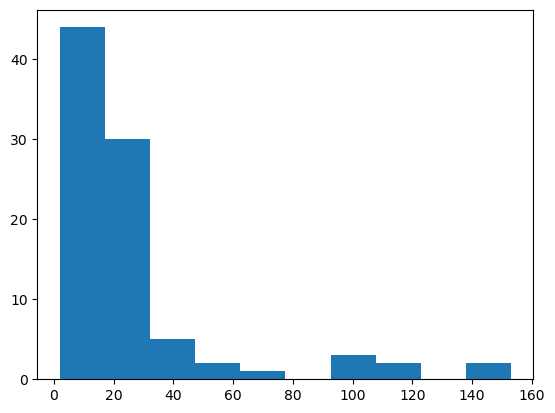

In [ ]:
plt.hist(data.where(data['Watercolor'] == 1).dropna()['price'].astype(float))

(array([55.,  9.,  3.,  0.,  1.,  1.,  2.,  2.,  1.,  2.]),
 array([  3.54 ,  73.186, 142.832, 212.478, 282.124, 351.77 , 421.416,
        491.062, 560.708, 630.354, 700.   ]),
 <BarContainer object of 10 artists>)

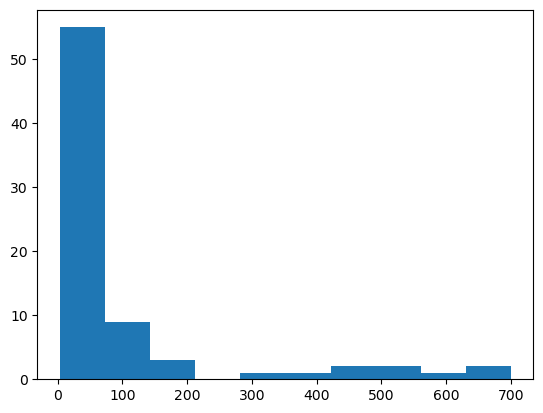

In [ ]:
plt.hist(data.where(data['Paint'] == 1).dropna()['price'].astype(float))

(array([10.,  1.,  3.,  9.,  1.,  1.,  0.,  0.,  0.,  2.]),
 array([ 4.08 ,  7.672, 11.264, 14.856, 18.448, 22.04 , 25.632, 29.224,
        32.816, 36.408, 40.   ]),
 <BarContainer object of 10 artists>)

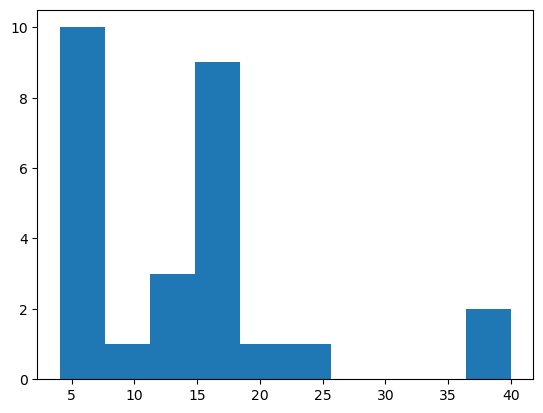

In [ ]:
plt.hist(data.where(data['Nature'] == 1).dropna()['price'].astype(float))

## Cheap categories

Text(0, 0.5, 'Average Price')

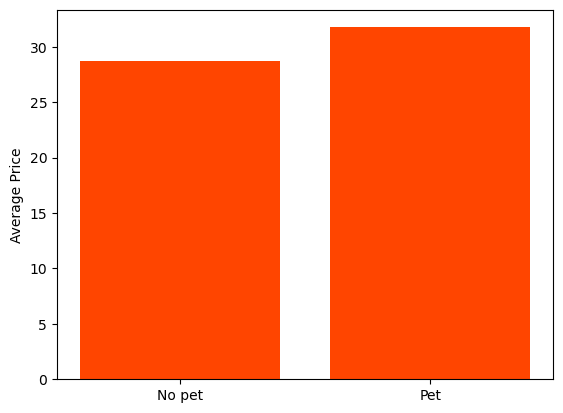

In [ ]:
avg_price_pet = np.mean(data_cheap.where(data_cheap['Pet'] == 1).dropna()['price'].astype(float))
avg_price_no_pet = np.mean(data_cheap.where(data_cheap['Pet'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No pet', 'Pet'], height=[avg_price_no_pet, avg_price_pet], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

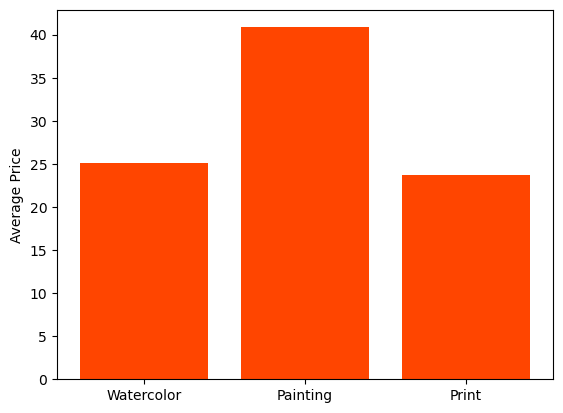

In [ ]:
avg_price_watercolor = np.mean(data_cheap.where(data_cheap['Watercolor'] == 1).dropna()['price'].astype(float))
avg_price_painting = np.mean(data_cheap.where((data_cheap['Paint'] == 1) | (data_cheap['Painting'] == 1)).dropna()['price'].astype(float))
avg_price_print = np.mean(data_cheap.where(data_cheap['Print'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Watercolor', 'Painting', 'Print'], height=[avg_price_watercolor, avg_price_painting, avg_price_print], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

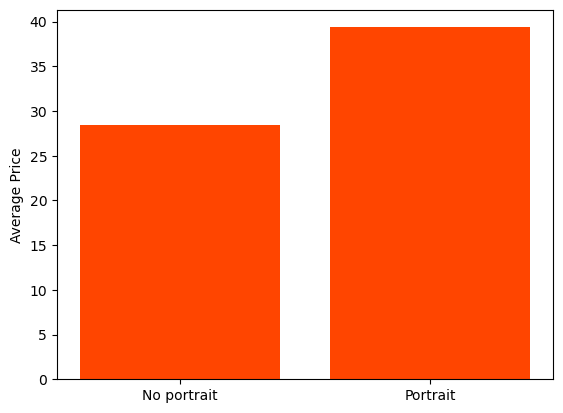

In [ ]:
avg_price_portrait = np.mean(data_cheap.where(data_cheap['Portrait'] == 1).dropna()['price'].astype(float))
avg_price_no_portrait = np.mean(data_cheap.where(data_cheap['Portrait'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No portrait', 'Portrait'], height=[avg_price_no_portrait, avg_price_portrait], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

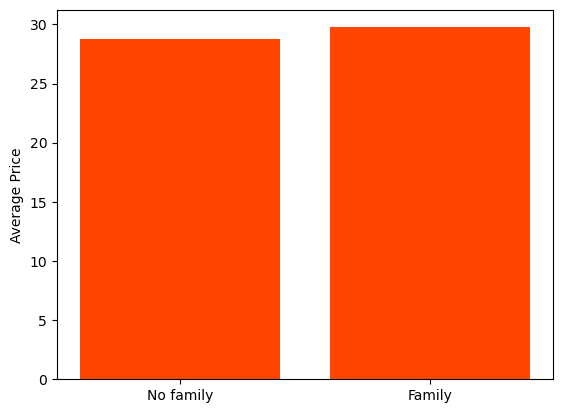

In [ ]:
avg_price_family = np.mean(data_cheap.where(data_cheap['Family'] == 1).dropna()['price'].astype(float))
avg_price_no_family = np.mean(data_cheap.where(data_cheap['Family'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No family', 'Family'], height=[avg_price_no_family, avg_price_family], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

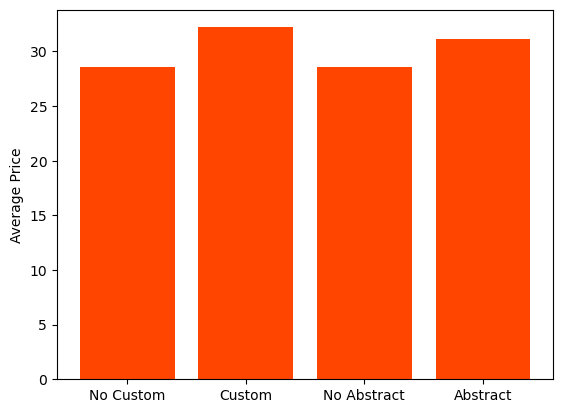

In [ ]:
avg_price = np.mean(data_cheap.where(data_cheap['Custom'] == 1).dropna()['price'].astype(float))
avg_price_no = np.mean(data_cheap.where(data_cheap['Custom'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No Custom', 'Custom'], height=[avg_price_no, avg_price], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

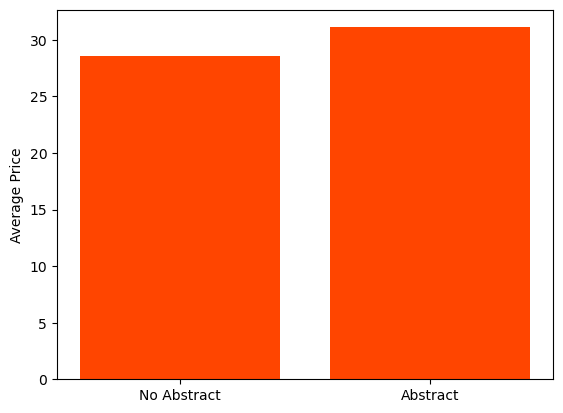

In [ ]:
avg_price = np.mean(data_cheap.where(data_cheap['Abstract'] == 1).dropna()['price'].astype(float))
avg_price_no = np.mean(data_cheap.where(data_cheap['Abstract'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No Abstract', 'Abstract'], height=[avg_price_no, avg_price], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

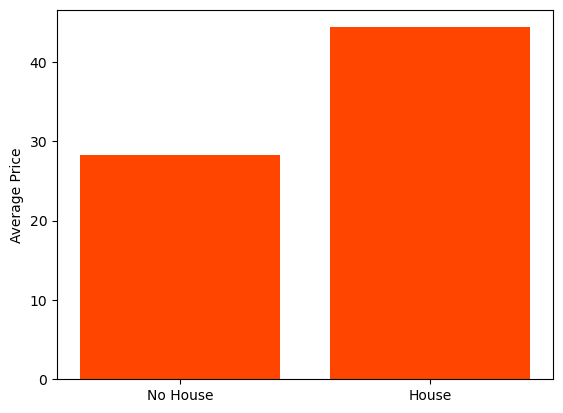

In [ ]:
avg_price = np.mean(data_cheap.where(data_cheap['House'] == 1).dropna()['price'].astype(float))
avg_price_no = np.mean(data_cheap.where(data_cheap['House'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No House', 'House'], height=[avg_price_no, avg_price], color = 'orangered')
plt.ylabel('Average Price')

## All cheap categories

Text(0, 0.5, 'Average Price')

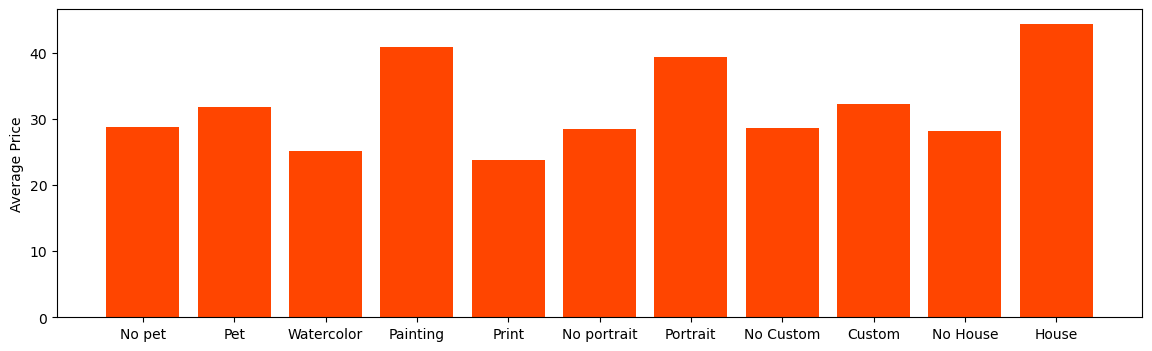

In [ ]:
plt.figure(figsize=(14, 4))
avg_price_pet = np.mean(data_cheap.where(data_cheap['Pet'] == 1).dropna()['price'].astype(float))
avg_price_no_pet = np.mean(data_cheap.where(data_cheap['Pet'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No pet', 'Pet'], height=[avg_price_no_pet, avg_price_pet], color = 'orangered')
plt.ylabel('Average Price')

avg_price_watercolor = np.mean(data_cheap.where(data_cheap['Watercolor'] == 1).dropna()['price'].astype(float))
avg_price_painting = np.mean(data_cheap.where((data_cheap['Paint'] == 1) | (data_cheap['Painting'] == 1)).dropna()['price'].astype(float))
avg_price_print = np.mean(data_cheap.where(data_cheap['Print'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Watercolor', 'Painting', 'Print'], height=[avg_price_watercolor, avg_price_painting, avg_price_print], color = 'orangered')
plt.ylabel('Average Price')

avg_price_portrait = np.mean(data_cheap.where(data_cheap['Portrait'] == 1).dropna()['price'].astype(float))
avg_price_no_portrait = np.mean(data_cheap.where(data_cheap['Portrait'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No portrait', 'Portrait'], height=[avg_price_no_portrait, avg_price_portrait], color = 'orangered')
plt.ylabel('Average Price')

avg_price = np.mean(data_cheap.where(data_cheap['Custom'] == 1).dropna()['price'].astype(float))
avg_price_no = np.mean(data_cheap.where(data_cheap['Custom'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No Custom', 'Custom'], height=[avg_price_no, avg_price], color = 'orangered')
plt.ylabel('Average Price')

avg_price = np.mean(data_cheap.where(data_cheap['House'] == 1).dropna()['price'].astype(float))
avg_price_no = np.mean(data_cheap.where(data_cheap['House'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No House', 'House'], height=[avg_price_no, avg_price], color = 'orangered')
plt.ylabel('Average Price')

## Expensive listings exploration

Text(0, 0.5, 'Average Price')

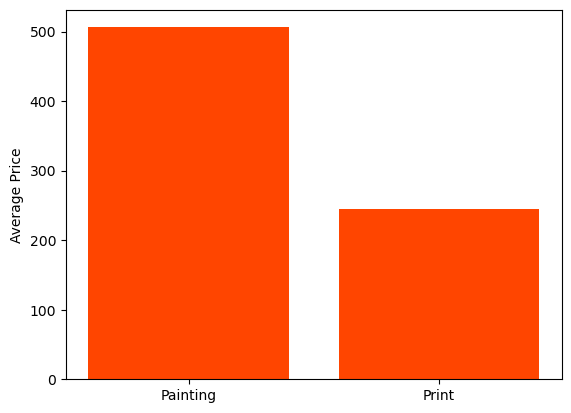

In [ ]:
# avg_price_watercolor = np.mean(data_expensive.where(data_expensive['Watercolor'] == 1).dropna()['price'].astype(float))
avg_price_painting = np.mean(data_expensive.where((data_expensive['Paint'] == 1) | (data_expensive['Painting'] == 1)).dropna()['price'].astype(float))
avg_price_print = np.mean(data_expensive.where(data_expensive['Print'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Painting', 'Print'], height=[avg_price_painting, avg_price_print], color = 'orangered')
plt.ylabel('Average Price')

In [ ]:
data_expensive.where(data_expensive['Portrait'] == 0).dropna()['price'].astype(float)

39      225.00
43      313.65
68      390.22
192     500.00
200     558.84
         ...  
970     441.15
1031    300.00
1045    435.00
1050    964.10
1064    325.00
Name: price, Length: 65, dtype: float64

Text(0, 0.5, 'Average Price')

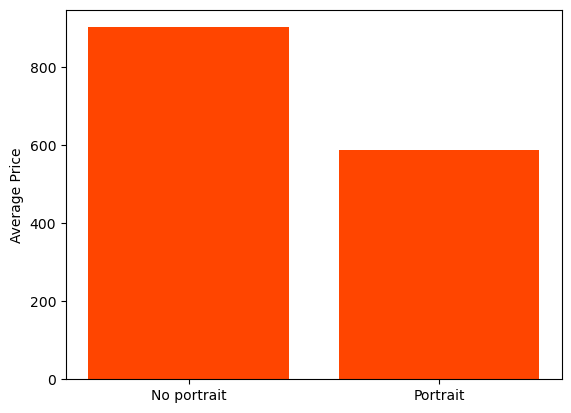

In [ ]:
avg_price_portrait = np.mean(data_expensive.where(data_expensive['Portrait'] == 1).dropna()['price'].astype(float))
avg_price_no_portrait = np.mean(data_expensive.where(data_expensive['Portrait'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No portrait', 'Portrait'], height=[avg_price_no_portrait, avg_price_portrait], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

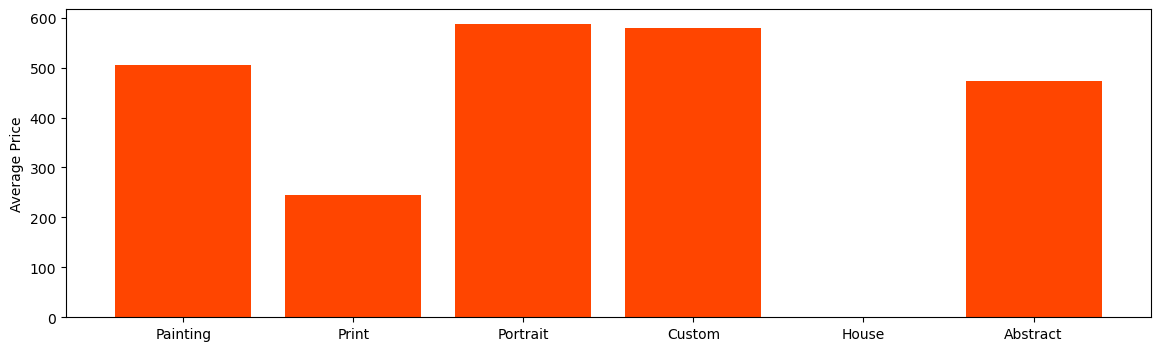

In [ ]:
plt.figure(figsize=(14, 4))
avg_price_pet = np.mean(data_expensive.where(data_expensive['Pet'] == 1).dropna()['price'].astype(float))
# avg_price_no_pet = np.mean(data_expensive.where(data_expensive['Pet'] == 0).dropna()['price'].astype(float))
plt.bar(x=['Pet'], height=[avg_price_pet], color = 'orangered')

avg_price_watercolor = np.mean(data_expensive.where(data_expensive['Watercolor'] == 1).dropna()['price'].astype(float))
avg_price_painting = np.mean(data_expensive.where((data_expensive['Paint'] == 1) | (data_expensive['Painting'] == 1)).dropna()['price'].astype(float))
avg_price_print = np.mean(data_expensive.where(data_expensive['Print'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Watercolor', 'Painting', 'Print'], height=[avg_price_watercolor, avg_price_painting, avg_price_print], color = 'orangered')

avg_price_portrait = np.mean(data_expensive.where(data_expensive['Portrait'] == 1).dropna()['price'].astype(float))
# avg_price_no_portrait = np.mean(data_expensive.where(data_expensive['Portrait'] == 0).dropna()['price'].astype(float))
plt.bar(x=['Portrait'], height=[avg_price_portrait], color = 'orangered')

avg_price = np.mean(data_expensive.where(data_expensive['Custom'] == 1).dropna()['price'].astype(float))
# avg_price_no = np.mean(data_expensive.where(data_expensive['Custom'] == 0).dropna()['price'].astype(float))
plt.bar(x=['Custom'], height=[avg_price], color = 'orangered')

avg_price = np.mean(data_expensive.where(data_expensive['House'] == 1).dropna()['price'].astype(float))
# avg_price_no = np.mean(data_expensive.where(data_expensive['House'] == 0).dropna()['price'].astype(float))
plt.bar(x=['House'], height=[avg_price], color = 'orangered')

avg_price = np.mean(data_expensive.where(data_expensive['Abstract'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Abstract'], height=[avg_price], color = 'orangered')
avg_price = np.mean(data_expensive.where(data_expensive['Family'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Family'], height=[avg_price], color = 'orangered')
avg_price = np.mean(data_expensive.where(data_expensive['Nature'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Nature'], height=[avg_price], color = 'orangered')

plt.ylabel('Average Price')

In [ ]:
data_expensive

,name,price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom,Abstract,House
20,Custom Pastel Portrait Painting of Child from ...,650.00,[],0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
39,"Tree Stump Print, Utah Art, Tree Blocks, Woodc...",225.00,[],0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,"Portofino Italy Painting on Canvas, Original P...",313.65,[],0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
52,Baby portrait. Custom Pastel Portrait Painting...,600.00,[],0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
68,"Fruit oil painting still life, fruit wall art,...",390.22,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,"Water Lily Painting on Canvas, Original Art, F...",441.15,[],0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1031,Modern Abstract Aluminum Metal Sculpture Garde...,300.00,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1045,Flock - 11 Porcelain ceramic wall art swallows...,435.00,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1050,Mr Toad - limited edition bronze,964.10,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_expensive.where(data_expensive['Portrait'] == 1).dropna()

,name,price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom,Abstract,House
20,Custom Pastel Portrait Painting of Child from ...,650.0,[],0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
52,Baby portrait. Custom Pastel Portrait Painting...,600.0,[],0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
303,"Portrait painting, Pastel of a boy",550.0,[],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
706,"Small Size Pastel Portrait Painting, baby port...",550.0,[],0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
